In [1]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

super_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{super_folder}/morphing_annealing_4d09_filtered_subset/"
folder=f"{pocket_fit_folder}/prediction_step_4/"
step_db_file=f"{pocket_fit_folder}/ddG_step_4_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step4_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step4_dG.pickle"

energy_folder="/home/energy/ykhalak/ML_dG/pde2_dG/generators/structures/set_4"
all_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step4_dG.pickle"
all_no_core_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step4_dG.pickle"

settings_folder=folder+"/combined_repr_search_with_repeats_and_mparam_scan/settings/"
os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol

import sys
#sys.path.insert(0, folder)
#sys.path.insert(0, f"{pocket_fit_folder}/prediction_step_0/")
sys.path.append(pocket_fit_folder)
#sys.path.append(folder)
sys.path.append(f"{pocket_fit_folder}/prediction_step_0/")

# debug

# Define representation blocks

In [2]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

no_core_flags_2D=[dataBlocks.no_core_MACCS, dataBlocks.no_core_Descriptors, dataBlocks.no_core_Graph_desc, dataBlocks.no_core_BCUT2D]
no_core_flags_3D=[dataBlocks.no_core_EState_FP, dataBlocks.no_core_Pharmacophore_feature_map,
          dataBlocks.no_core_MOE, dataBlocks.no_core_MQN,
          # dataBlocks.no_core_GETAWAY, 
          dataBlocks.no_core_AUTOCORR2D,
          dataBlocks.no_core_AUTOCORR3D, dataBlocks.no_core_WHIM, dataBlocks.no_core_RDF,
          #dataBlocks.no_core_USR, dataBlocks.no_core_USRCUT,
          dataBlocks.no_core_PEOE_VSA, dataBlocks.no_core_SMR_VSA,
          dataBlocks.no_core_SlogP_VSA, dataBlocks.no_core_MORSE]

# import training script

In [3]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general_with_ensemble_summary_model' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model
from owl_trainer_w_params_general_with_ensemble_summary_model import *

# Scan through represenatation combinations

### full ligs

In [4]:
sfiles=[]
sfiles_step=[]

normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=20
hl_depth=3
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
#shiftY=False
shiftY=True

redo=False

# nsteps=4

# sfiles=[]
# sfiles_step=[]

nrepeats=5

reprs=[]
names=["2D_3D","MDenerg","atom_hot", "2D_3D_MDenerg_atom_hot"]
best_hlws=[20,5,50,50]
best_hlds=[3,3,3,3]
#2D_3D
representation_flags=[0]*len(dataBlocks)
for b in flags_2D:
    representation_flags[int(b)]=1
for b in flags_3D:
    representation_flags[int(b)]=1
reprs.append(representation_flags)
#MDenerg
representation_flags=[0]*len(dataBlocks)
representation_flags[int(dataBlocks.MDenerg)]=1
reprs.append(representation_flags)
#atom_hot
representation_flags=[0]*len(dataBlocks)
representation_flags[int(dataBlocks.atom_hot)]=1
reprs.append(representation_flags)
# 2D_3D + MDenerg + atom_hot
for b in flags_2D:
    representation_flags[int(b)]=1
for b in flags_3D:
    representation_flags[int(b)]=1
representation_flags[int(dataBlocks.MDenerg)]=1
representation_flags[int(dataBlocks.atom_hot)]=1
reprs.append(representation_flags)

for ri,representation_flags in enumerate(reprs):
    hl_w=best_hlws[ri]
    hl_depth=best_hlds[ri]
    
    for step in [4]:
        cur_settings_folder=f"{pocket_fit_folder}/prediction_step_{step}/combined_repr_search_with_repeats_and_mparam_scan/settings/"
        os.makedirs(cur_settings_folder, exist_ok=True)


        for rep in range(nrepeats):
            dr_name=f"{names[ri]}_repeat{rep}"

            settings=[
                representation_flags, dr_name, normalize_x, shuffle_seed,
                n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
                impfilt, X_filter,
                weighted, shiftY, use_dropout
                ]

            sha = hashlib.sha256()
            sha.update(pickle.dumps(settings))
            settings_hash=dr_name+"_"+sha.hexdigest()[:10]

            settings_fname=cur_settings_folder+f"{settings_hash}.pickle"
            if(os.path.exists(settings_fname)):
                with open(settings_fname, 'rb') as f:
                    settings_loaded, metrics = pickle.load(f)
                    if(metrics is not None and not redo):
                        print(f"{settings_fname} is already trained.")
                    else:
                        print(f"{settings_fname} exists but is not trained yet.")
    #                     sfiles.append(settings_fname)
    #                     sfiles_step.append(step)
            else:
                pickle.dump( (settings, None), open( settings_fname, "wb" ) )
    #             sfiles.append(settings_fname)
    #             sfiles_step.append(step)

            sfiles.append(settings_fname)
            sfiles_step.append(step)

/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_repeat0_52be97ba2d.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_repeat1_59513b0163.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_repeat2_359b662a56.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_repeat3_dcf8d95574.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/s

# Run locally

In [10]:
for i,f in tqdm(enumerate(sfiles)):
    settings_fname=f
    step=sfiles_step[i]
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is not None):
            continue;

    print("######################################")
    print(settings_fname)
    print("######################################")
#     raise()

    train_model_with_settings_general_ensemble(
              settings_fname, False,
              #torch.device("cpu"),
              torch.device("cuda:0"),
              True,
              datafolder=f"{pocket_fit_folder}/prediction_step_5/cached_reprs/",
              #datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search",
              save_folder_base=f"{pocket_fit_folder}/prediction_step_{step}/combined_repr_search_with_repeats_and_mparam_scan",
              all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle",
              all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle",
              validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands.pickle",
              no_core_validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands_no_core.pickle",
              train_summary_model=True,
              predict_all_ligs=False
             )
    raise()

print("Done.")

9it [00:00, 40.37it/s]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/atom_hot_repeat0_8a0b6142d6.pickle
######################################




Representation: atom_hot_repeat0
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-02-24 15:03:26.739722
Read ligands 2022-02-24 15:03:29.859874
# of training ligands found: 495 2022-02-24 15:03:29.885340
# starting ligands: 495 2022-02-24 15:03:30.075168
Finished setting up weights 2022-02-24 15:03:30.093804
Building the internal_filtered_cache needs 3427.744903564453 MB, more than the 0.0 MB limit. SKIPPING and will read samples from HDD each time instead.
Found normalization factors across all ligands 2022-02-24 15:03:38.440850
Set up validation dataset 2022-02-24 15:03:38.7139

9it [00:12, 40.37it/s]

There are 13169 features 2022-02-24 15:03:38.784001


10it [00:49,  5.00s/it]


ValueError: operands could not be broadcast together with shapes (9721,) (13169,) 

# Copy step 4 databases to energy

In [ ]:
import shutil
step=4

all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle"

energy_folder_on_workstation="/netmount/energy/ykhalak/ML_dG/pde2_dG/generators/structures/set_4"
all_ligs_db_file_energy=f"{energy_folder_on_workstation}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle"
all_no_core_ligs_db_file_energy=f"{energy_folder_on_workstation}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle"

shutil.copy(all_ligs_db_file, all_ligs_db_file_energy)
shutil.copy(all_no_core_ligs_db_file, all_no_core_ligs_db_file_energy)

# Run on moa

In [5]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

fits_per_job=1

cmd_str=f"source /etc/profile; module load sge;"
cmd_str_SLURM=f"source /etc/profile;"

fits_written_to_jobs=0
fits_not_trained=0

for step in [4]:
    job_id=0
    fits_this_job=0
    fit_commands_this_job=""
    
    cwd=f"{pocket_fit_folder}/prediction_step_{step}/combined_repr_search_with_repeats_and_mparam_scan/local_runs/"
    os.makedirs(cwd, exist_ok=True)

    save_folder_base=f"{pocket_fit_folder}/prediction_step_{step}/combined_repr_search_with_repeats_and_mparam_scan"
    all_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle"
    all_no_core_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle"
    validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands.pickle"
    no_core_validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands_no_core.pickle"
    
    for i,f in enumerate(tqdm(sfiles)):
        settings_fname=f
    #     step=sfiles_step[i]
        if(not os.path.exists(settings_fname)):
            continue;
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is None and step==sfiles_step[i]):
                fits_not_trained+=1
                fits_this_job+=1
                fit_commands_this_job+=f"""
python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/owl_trainer_w_params_general_with_ensemble_summary_model.py\
 -v -f {settings_fname} --datafolder $TMPDIR --save_folder_base {save_folder_base}\
 --ligsf {all_ligs_db_file_energy} --nocoref {all_no_core_ligs_db_file_energy}\
 --valsf {validation_db_file} --nocorevalsf {no_core_validation_db_file}\
 --no_pred --sm

 """

        if(fits_this_job>=fits_per_job or (i>=len(sfiles)-1 and fits_this_job>0)):

            jobscript_str=f"""#!/bin/bash

#$ -S /bin/bash
#$ -pe openmp_fast 10
#$ -q *
#$ -N pytorch_GPU_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=5:00:00
#$ -wd {cwd}

#SBATCH --job-name=pytorch_SLURM_GPU_worker_{job_id}
#SBATCH --get-user-env
#SBATCH --gres=gpu:1              # number of GPUs requested
#SBATCH --ntasks=1                # Number of MPI process
#SBATCH --cpus-per-task=10        # CPU cores per MPI process
##SBATCH -p p24,p20,p16,p10,p08,p06    # partitions to use
#SBATCH -p p10,p08,p06            # partitions to use
#SBATCH -t 5:00:0                 # hours:min:sec
#SBATCH --chdir={cwd}
#SBATCH -e repr_scan_{job_id}-%j.err
#SBATCH -o repr_scan_{job_id}-%j.out

if [ -n "$NHOSTS" ]; then
    echo "Env. variable NHOSTS found, assuming we are using SGE."
    module load shared                           # access to modules in /cm/shared
else
    echo "Env. variable NHOSTS not set, assuming we are using SLURM."
    export NHOSTS=$SLURM_JOB_NUM_NODES
    export NSLOTS=$SLURM_CPUS_PER_TASK
fi

echo NHOSTS=$NHOSTS
echo NSLOTS=$NSLOTS
echo TMPDIR=$TMPDIR
hostname

echo "#################################################"

export OMP_NUM_THREADS=$NSLOTS
export MKL_NUM_THREADS=$NSLOTS

source ~/.ML_v2_profile
#source ~/.ML_v2_on_energy_profile

#cp /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search/deployable_training_data_with_validation_ligs.tar.gz $TMPDIR/.
cp /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_5/cached_reprs/deployable_training_data_with_validation_ligs.tar.gz $TMPDIR/.
cd $TMPDIR
tar -zxf deployable_training_data_with_validation_ligs.tar.gz
cd {cwd}

echo "Done extracting data"

{fit_commands_this_job}
"""

            jobscript_fn=cwd+"/jobscript_{}".format(job_id)
            with open(jobscript_fn,"w") as f:
                f.write(jobscript_str)

            cmd_str+=f" cd {cwd}; qsub {jobscript_fn};"
            cmd_str_SLURM+=f" sbatch {jobscript_fn};"

            job_id+=1
            
            fits_written_to_jobs+=fits_this_job
            fit_commands_this_job=""
            fits_this_job=0
            
            

    print(len(sfiles), fits_not_trained, fits_written_to_jobs)
#     print(fits_this_job, i)
#     raise()

print("Submitting.")
# ssh_cmd_arr=["ssh", "owl", cmd_str]
ssh_cmd_arr=["ssh", "moa2", cmd_str_SLURM]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
outs, _ = process.communicate()
process.wait()
print('== subprocess exited with rc =', process.returncode)
print(outs.decode('utf-8'))
print("Done.")

100%|██████████| 20/20 [00:00<00:00, 97.86it/s]


20 10 10
Submitting.
== subprocess exited with rc = 0
Submitted batch job 546063
Submitted batch job 546064
Submitted batch job 546065
Submitted batch job 546066
Submitted batch job 546067
Submitted batch job 546068
Submitted batch job 546069
Submitted batch job 546070
Submitted batch job 546071
Submitted batch job 546072

Done.


# Predict dG locally

In [6]:
for i,f in enumerate(tqdm(sfiles)):
    settings_fname=f
    step=sfiles_step[i]
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            continue;
        elif(metrics.summary_model_best_pred is not None):
            continue;

    print("######################################")
    print(settings_fname, "step", step)
    print("######################################")
#     raise()

    Predict_from_saved_models_ensemble(settings_fname, redo=True,
                                      #torch.device("cpu"),
                                      device=torch.device("cuda:0"),
                                      show_progress=True,
                                      #datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search",
                                      datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0",
                                      save_folder_base=f"{pocket_fit_folder}/prediction_step_{step}/combined_repr_search_with_repeats_and_mparam_scan",
                                      all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle",
                                      all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle",
                                      max_cache_Mem_MB=1024*6,
                                     )
#     raise()

print("Done.")

 50%|█████     | 10/20 [00:00<00:00, 47.54it/s]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/atom_hot_repeat0_8a0b6142d6.pickle step 4
######################################
Representation: atom_hot_repeat0
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:40:11.315109


 50%|█████     | 10/20 [00:10<00:00, 47.54it/s]

Found normalization factors across all ligands 2022-03-02 20:42:05.183533
Loaded models 2022-03-02 20:42:19.933521
summary_models were found.
Finished predictions 2022-03-02 20:42:35.265782


 55%|█████▌    | 11/20 [02:26<03:09, 21.09s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/atom_hot_repeat1_3ad5bdd847.pickle step 4
######################################
Representation: atom_hot_repeat1
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:42:37.873534
Found normalization factors across all ligands 2022-03-02 20:44:20.940241
Loaded models 2022-03-02 20:44:22.691888
summary_models were found.
Finished predictions 2022-03-02 20:44:37.294643


 60%|██████    | 12/20 [04:29<05:06, 38.36s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/atom_hot_repeat2_2dc8c0b0d3.pickle step 4
######################################
Representation: atom_hot_repeat2
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:44:40.246659
Found normalization factors across all ligands 2022-03-02 20:47:04.152936
Loaded models 2022-03-02 20:47:06.658562
summary_models were found.
Finished predictions 2022-03-02 20:47:21.570381


 65%|██████▌   | 13/20 [07:13<07:21, 63.09s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/atom_hot_repeat3_c728a7d21f.pickle step 4
######################################
Representation: atom_hot_repeat3
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:47:24.907896
Found normalization factors across all ligands 2022-03-02 20:49:52.068016
Loaded models 2022-03-02 20:49:54.918408
summary_models were found.
Finished predictions 2022-03-02 20:50:09.859987


 70%|███████   | 14/20 [10:01<08:36, 86.08s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/atom_hot_repeat4_ea818366da.pickle step 4
######################################
Representation: atom_hot_repeat4
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:50:13.114633
Found normalization factors across all ligands 2022-03-02 20:52:44.924743
Loaded models 2022-03-02 20:52:47.889990
summary_models were found.
Finished predictions 2022-03-02 20:53:02.720024


 75%|███████▌  | 15/20 [12:54<08:53, 106.72s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_MDenerg_atom_hot_repeat0_7f39710079.pickle step 4
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat0
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:53:05.921812
Found normalization factors across all ligands 2022-03-02 20:55:32.231470
Loaded models 2022-03-02 20:55:35.006760
summary_models were found.
Finished predictions 2022-03-02 20:55:49.854626


 80%|████████  | 16/20 [15:41<08:08, 122.08s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_MDenerg_atom_hot_repeat1_e98aa85b65.pickle step 4
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat1
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:55:53.189451
Found normalization factors across all ligands 2022-03-02 20:58:01.037751
Loaded models 2022-03-02 20:58:06.823970
summary_models were found.
Finished predictions 2022-03-02 20:58:23.923771


 85%|████████▌ | 17/20 [18:16<06:31, 130.61s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_MDenerg_atom_hot_repeat2_1e69b489e1.pickle step 4
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat2
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 20:58:27.321755
Found normalization factors across all ligands 2022-03-02 21:00:24.837044
Loaded models 2022-03-02 21:00:29.659473
summary_models were found.
Finished predictions 2022-03-02 21:00:46.454582


 90%|█████████ | 18/20 [20:38<04:27, 133.90s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_MDenerg_atom_hot_repeat3_eac04249f1.pickle step 4
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat3
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 21:00:49.876456
Found normalization factors across all ligands 2022-03-02 21:02:56.780872
Loaded models 2022-03-02 21:03:01.210253
summary_models were found.
Finished predictions 2022-03-02 21:03:18.846445


 95%|█████████▌| 19/20 [23:10<02:19, 139.10s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_4/combined_repr_search_with_repeats_and_mparam_scan/settings/2D_3D_MDenerg_atom_hot_repeat4_b48aa94cad.pickle step 4
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat4
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: True
2022-03-02 21:03:22.210211
Found normalization factors across all ligands 2022-03-02 21:05:21.875878
Loaded models 2022-03-02 21:05:26.532448
summary_models were found.
Finished predictions 2022-03-02 21:05:44.449215


100%|██████████| 20/20 [25:36<00:00, 76.84s/it] 

Done.


# Find which ligands are most strongly binding for 2D_3D

## load predictions

In [12]:
step=4
cur_settings_folder=f"{pocket_fit_folder}/prediction_step_{step}/combined_repr_search_with_repeats_and_mparam_scan/settings/"

wanted_repr="2D_3D"

P=[]
sfiles = next(os.walk(cur_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in sfiles:
    settings_fname=cur_settings_folder+"/"+fn
    metrics=None
    with open(settings_fname, 'rb') as f:
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception as e:
            print(f"problem with {fn}")
            raise(e)

    if(metrics is not None):
        key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}_hld{settings_loaded[6]}"
        if(wanted_repr+"_repeat" in key):
            P.append(metrics.best_pred[0])
            
P=np.mean(np.array(P), axis=0)

## exclude validation ligands and select unmeasured ones

In [14]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

# find validation and non-validation ligands
training_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG//aligned_w_pmx_library_new_structures_similar2xrays.pickle"
with open(training_databse_fn, 'rb') as f:
    expt_ligs = pickle.load(f)
expt_ligs=[l for l in expt_ligs if not("<" in l.GetProp("[Q] hPDE2_pIC50") or ">" in l.GetProp("[Q] hPDE2_pIC50"))]

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], expt_ligs, asSmiles=True)# print(unmatched)
matched_expt_ligs=[expt_ligs[i] for i in range(len(expt_ligs)) if not i in unmatched]

#filter out H's as R-groups
validation_ligs=[]
for i,l in enumerate(tqdm(res)):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        validation_ligs.append(matched_expt_ligs[i])
print(f"found {len(validation_ligs)} validation ligands")

del expt_ligs, matched_expt_ligs
_=gc.collect()

100%|██████████| 136/136 [00:00<00:00, 417894.02it/s]


found 69 validation ligands


In [16]:
from rdkit.Chem import rdmolops
validation_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in validation_ligs]

validation_ids_in_set4f=[]
validation_ids_in_validation_subset=[]
unmeasured_ids_in_set4f=[]
measured_ids_in_set4f=[]

#load only if not curretly loaded
try:
    ligs_set4f
except NameError:
    with open(all_ligs_db_file, 'rb') as f:
        ligs_set4f = pickle.load(f)

for i,lig in enumerate(tqdm(ligs_set4f)):
    smi=Chem.MolToSmiles(rdmolops.RemoveHs(lig))
    if(smi in validation_smiles):
        validation_ids_in_set4f.append(i)
        j=validation_smiles.index(smi)
        validation_ids_in_validation_subset.append(j)
    elif(not lig.HasProp('dG')):
        unmeasured_ids_in_set4f.append(i)
    else:
        measured_ids_in_set4f.append(i)

100%|██████████| 34114/34114 [00:09<00:00, 3621.76it/s]


In [18]:
unmeasured_ids_in_set4f=np.array(unmeasured_ids_in_set4f)

## select the new ligands

In [19]:
unmeasured_P=P[unmeasured_ids_in_set4f]
sorted_unmeasured_ids=unmeasured_ids_in_set4f[np.argsort(unmeasured_P)]

new_lig_ids=sorted_unmeasured_ids[:100]
print(P[new_lig_ids])

[-15.923245  -15.735013  -15.708315  -15.639949  -15.533818  -15.482387
 -15.346336  -15.308678  -15.294507  -15.249585  -15.246776  -15.244931
 -15.238063  -15.21962   -15.2161    -15.21163   -15.204824  -15.197339
 -15.194158  -15.19177   -15.185226  -15.183749  -15.167659  -15.166733
 -15.157293  -15.155154  -15.15      -15.149401  -15.149264  -15.147821
 -15.147243  -15.146925  -15.141462  -15.141093  -15.139257  -15.137692
 -15.136614  -15.119438  -15.103302  -15.0911045 -15.084885  -15.077202
 -15.073204  -15.07181   -15.062813  -15.045549  -15.044432  -15.036519
 -15.029455  -15.015971  -15.015936  -15.015521  -15.013792  -15.013069
 -15.010013  -15.002245  -14.999077  -14.995415  -14.994415  -14.991091
 -14.983793  -14.977473  -14.976145  -14.973932  -14.973126  -14.971733
 -14.970659  -14.970308  -14.967102  -14.96272   -14.9529705 -14.945231
 -14.939288  -14.938047  -14.937201  -14.936661  -14.935194  -14.934204
 -14.929697  -14.924484  -14.921918  -14.917625  -14.917158  -14

In [20]:
def grid_mols_with_annotation(mols, labels, sub_img_size=(250,250), mols_per_row=10, title="", annotation_size=22, title_size=25, y_offset=-20):
    """Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title"""
    
    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size, maxMols=len(mols), returnPNG=False)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size[0]/2, sub_img_size[1]+y_offset)
    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in labels:
        plt.annotate(cmpd_text, text_pos, fontsize=annotation_size, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0]+sub_img_size[0], text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size[0]/2, text_pos[1] + sub_img_size[1])

    ax.imshow(img, origin="upper")

In [21]:
with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)

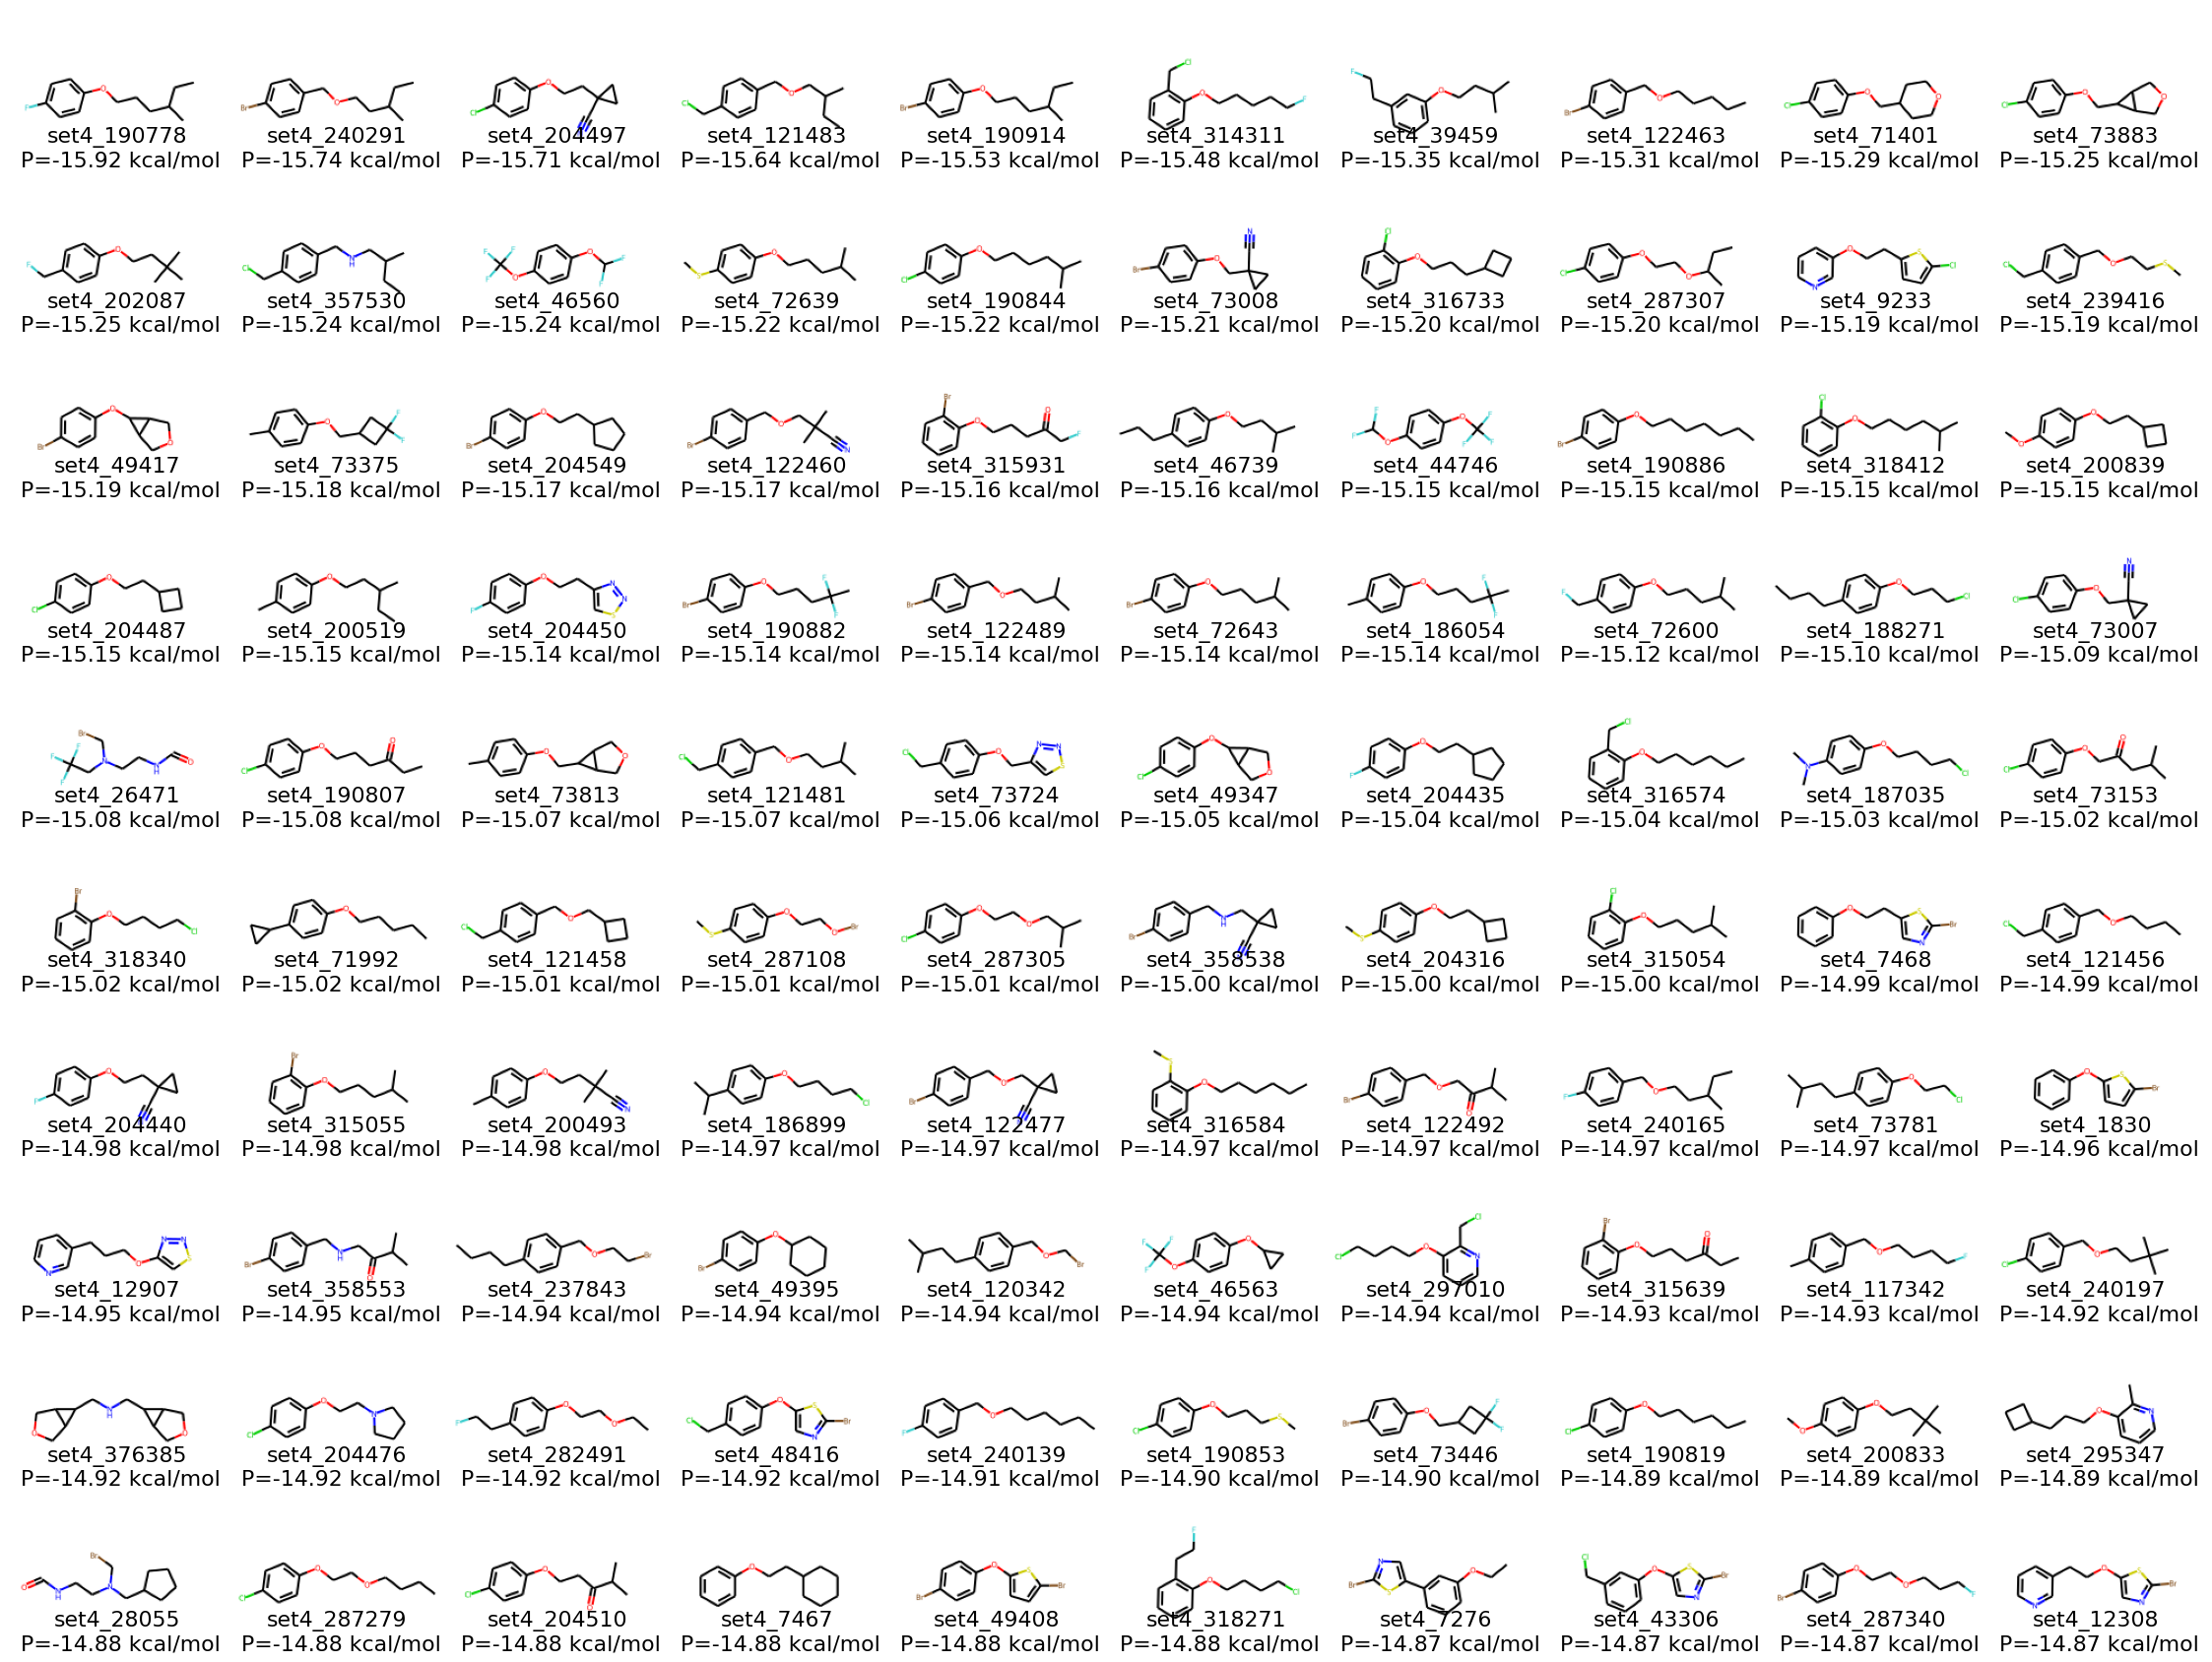

In [23]:
selected_ligs=[ligs_set4f[i] for i in new_lig_ids]
legends=[f"{ligs_set4f[i].GetProp('ID')}\n P={P[i]:.2f} kcal/mol" for i in new_lig_ids]

selected_RGroups=[Chem.MolFromSmiles(Chem.MolToSmiles(no_core_ligs_set4f[i])) for i in new_lig_ids]
grid_mols_with_annotation(selected_RGroups, legends,
                     sub_img_size =(200,150), mols_per_row=10, y_offset=-5)

In [24]:
with open( pocket_fit_folder+"/step_5_picks.pickle", "wb" ) as f:
    pickle.dump(selected_ligs, f)